#### Setup

In [1]:
import os
path = os.path.abspath(os.path.join("..", "language-modeling"))
%cd $path

/media/pips/Data/Projects/NLU-UniTN-2022/project/language-modeling


In [2]:
import yaml
import math
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report

import torch
import torch.nn.functional as F

from IPython.display import display

from cli import inference


/media/pips/Data/Projects/NLU-UniTN-2022/project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("configs/inference.yaml", "r") as f:
    inf_config = yaml.safe_load(f)

In [4]:
def load_pickle(filename: str):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [5]:
def plot_ppl_per_len(df):
    df = df[['lengths', 'loss']]
    df['lengths'] = df.apply(lambda x: list(x["lengths"])[0], axis=1)
    df = df.groupby("lengths").mean()
    df["ppl"] = df.apply(lambda x: math.exp(x["loss"]), axis=1)
    df.plot(
        y="ppl", 
        title="Perplexity by sequence length", 
        kind="bar",
        xlabel="Sentence length",
        ylabel="Average perplexity",
        rot=0,
        xticks=range(0, 70, 10),
        legend=False,)
    plt.show()

In [6]:
def fetch_predictions(outputs):
    outputs = torch.tensor(outputs) if len(outputs.shape) > 1 \
                                    else torch.tensor(outputs).unsqueeze(0)
    softmax = F.softmax(outputs, dim=1)
    predictions = torch.argmax(softmax, dim=1)
    return predictions.numpy()

def get_counts(df, col, lang):
    if col == "outputs":
        df[col] = df.apply(lambda pred: fetch_predictions(pred[col]), axis=1)
        
    counts = Counter()
    for row in df[col]:
        if col == "targets" and row.size < 2:
            row = [int(row)]
        counts.update(row)
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
    counts = {lang[int(k)]: v  for (k, v) in counts.items()}
    return counts

In [7]:
def plot_targets_vs_preds(targets, preds):
    targets_df = pd.DataFrame(targets.items(), columns=["word", "target_count"])
    total = targets_df["target_count"].sum()
    targets_df["target_freq"] = targets_df["target_count"] / total
    targets_df["pred_count"] = pd.Series(preds.values())
    targets_df["pred_count"] = targets_df["pred_count"].fillna(0).astype(int)
    targets_df["diff"] = targets_df["pred_count"] - targets_df["target_count"]
    targets_df["pred_freq"] = targets_df["pred_count"] / total
    return targets_df

In [31]:
def report(df, targets_counts, outputs_counts, lang, mode="most"):
    if mode == "most_present":
        ids = set([lang[w] for w in list(targets_counts.keys())[:20]])
    elif mode == "most_guessed":
        ids = set([lang[w] for w in list(outputs_counts.keys())[:20]])
    elif mode == "least_guessed":
        ids = set([lang[w] for w in list(outputs_counts.keys())[-20:]])
    targets = []
    preds = []
    for _, row in df.iterrows():
        rt = row["targets"].squeeze().tolist()
        rp = row["outputs"].squeeze().tolist()
        if isinstance(rt, int): rt = [rt]
        if isinstance(rp, int): rp = [rp]
        for t, p in zip(rt, rp):
            if (t in ids or p in ids):
                targets.append(t)
                preds.append(p)
    report = classification_report(targets, preds, labels=list(ids), target_names=[lang.ids2words[i] for i in ids], output_dict=True)
    display(pd.DataFrame(report).transpose())

In [34]:
def evaluate(experiment_name: str):
    results = load_pickle(f"results/outputs/{experiment_name}.pkl")
    lang = load_pickle("lang.pkl")
    df = pd.DataFrame(results)
    display(df)
    plot_ppl_per_len(df)
    targets = get_counts(df, "targets", lang)
    outputs = get_counts(df, "outputs", lang)
    diff = plot_targets_vs_preds(targets, outputs)
    pd.options.display.float_format = '{:.2%}'.format
    display(diff)
    pd.options.display.float_format = '{:.2}'.format
    report(df, targets, outputs, lang, mode="most_present")
    report(df, targets, outputs, lang, mode="most_guessed")
    # report(df, targets, outputs, lang, mode="least_guessed")
    del df

#### merity_ad_nohh_1024

In [10]:
experiment_name = "merity_ad_nohh_1024"

In [13]:
with open(f"configs/{experiment_name}.yaml") as config_file:
    config = yaml.safe_load(config_file)
print(inference(config, inf_config, "the"))

T: 1.00	=>	the surprising pace came in the july N causing paper in the u.s. effect a consumer <unk> was pegged at $ N million
T: 0.80	=>	the treasury will raise about $ N billion in short-term bills and annuities
T: 0.75	=>	the accord also includes a $ N million air force contract for power to consolidate the second-largest airline
T: 0.70	=>	the lack of <unk> money is too profitable
T: 0.50	=>	the real estate unit is n't a real estate



In [14]:
print(inference(config, inf_config, "the price"))

T: 1.00	=>	the price is at induce price
T: 0.80	=>	the price was unchanged to $ N million
T: 0.75	=>	the price of $ N a share
T: 0.70	=>	the price for the s&p N was equivalent to N N
T: 0.50	=>	the price was $ N



In [15]:
print(inference(config, inf_config, "it may"))

T: 1.00	=>	it may not always lock on european market
T: 0.80	=>	it may be far greater and more than N N of those in the stock exchange and many markets
T: 0.75	=>	it may be n't a separate <unk>
T: 0.70	=>	it may be <unk> by a <unk> plan
T: 0.50	=>	it may not be a <unk>



,inputs,targets,lengths,outputs,loss
0,"[142, 78, 54, 251, 2360, 405]","[78, 54, 251, 2360, 405, 10000]",[6],"[[-1.1988549, -1.2548482, -1.5607876, -1.18973...",5.4442177
1,"[315, 706, 32, 101, 934, 935, 936, 874, 251, 5...","[706, 32, 101, 934, 935, 936, 874, 251, 572, 5...",[37],"[[-1.500829, -1.65592, -1.2835016, -1.414056, ...",3.6605964
2,"[307, 954, 4419, 3882, 424, 32, 687, 27, 1745,...","[954, 4419, 3882, 424, 32, 687, 27, 1745, 1884...",[26],"[[-1.136029, -1.086591, -1.0284503, -1.2422093...",4.923312
3,"[32, 27, 935, 2737, 1292, 152, 32, 812, 33, 44...","[27, 935, 2737, 1292, 152, 32, 812, 33, 4402, ...",[32],"[[-1.3273237, -0.99297506, -0.9458163, -0.9323...",4.648102
4,"[812, 1623, 1375, 2569, 64, 2775, 95, 64, 32, ...","[1623, 1375, 2569, 64, 2775, 95, 64, 32, 2141,...",[24],"[[-1.2707372, -1.0347981, -1.4373713, -1.31372...",3.7722266
...,...,...,...,...,...
3756,"[853, 2574, 26, 312, 42, 32, 682, 4921, 4464, ...","[2574, 26, 312, 42, 32, 682, 4921, 4464, 504, ...",[22],"[[-0.6071999, -0.65143573, -0.29727638, -0.175...",4.5454426
3757,"[374, 2173, 380, 1287, 64, 220, 1729, 2083]","[2173, 380, 1287, 64, 220, 1729, 2083, 10000]",[8],"[[-0.68605363, -0.8292419, -0.30017054, -0.206...",5.2046256
3758,"[160, 710, 2378, 119, 3302, 374, 1134, 152, 55...","[710, 2378, 119, 3302, 374, 1134, 152, 556, 26...",[20],"[[-1.0581164, -1.2457604, -0.9231479, -0.82422...",5.3370314
3759,"[130, 26, 7649, 373, 130, 2573, 93, 32, 499, 4...","[26, 7649, 373, 130, 2573, 93, 32, 499, 40, 17...",[24],"[[-0.8072857, -1.0000955, -0.57780445, -0.4472...",4.3449206


/tmp/ipykernel_4677/2585029102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lengths'] = df.apply(lambda x: list(x["lengths"])[0], axis=1)


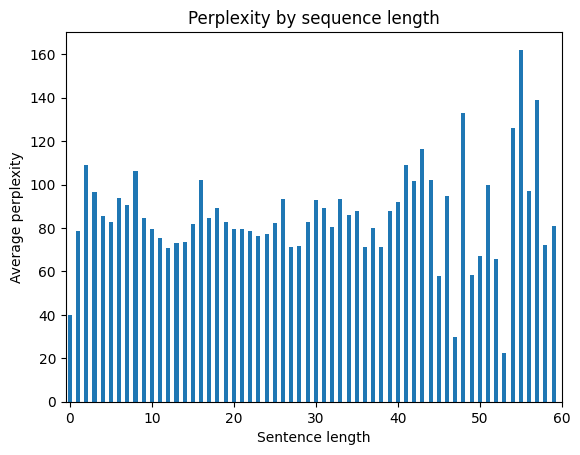

,word,target_count,target_freq,pred_count,diff,pred_freq
0,<unk>,4606,5.85%,16365,11759,20.80%
1,the,3968,5.04%,12146,8178,15.44%
2,<eos>,3761,4.78%,8679,4918,11.03%
3,N,2494,3.17%,3894,1400,4.95%
4,of,2182,2.77%,3034,852,3.86%
...,...,...,...,...,...,...
5973,external,1,0.00%,0,-1,0.00%
5974,wings,1,0.00%,0,-1,0.00%
5975,inside,1,0.00%,0,-1,0.00%
5976,instructed,1,0.00%,0,-1,0.00%


,precision,recall,f1-score,support
<eos>,0.29,0.67,0.41,3.8e+03
on,0.36,0.15,0.21,4.8e+02
<unk>,0.15,0.52,0.23,4.6e+03
N,0.57,0.7,0.63,2.5e+03
the,0.23,0.7,0.34,4e+03
$,0.36,0.55,0.44,5.4e+02
as,0.48,0.23,0.31,4.3e+02
a,0.22,0.24,0.23,1.7e+03
is,0.14,0.29,0.19,6.6e+02
of,0.36,0.63,0.46,2.2e+03


,precision,recall,f1-score,support
<eos>,0.29,0.67,0.41,3.8e+03
<unk>,0.15,0.52,0.23,4.6e+03
N,0.57,0.7,0.63,2.5e+03
are,0.14,0.35,0.2,3.6e+02
the,0.23,0.7,0.34,4e+03
$,0.36,0.55,0.44,5.4e+02
a,0.22,0.24,0.23,1.7e+03
is,0.14,0.29,0.19,6.6e+02
been,0.21,0.9,0.34,1.6e+02
of,0.36,0.63,0.46,2.2e+03


In [35]:
evaluate(experiment_name)